# War Modeling
## Money or Soldiers : What's more important

<img src="https://ipython-books.github.io/pages/chapter06_viz/04_d3_files/D3.png" width=500px>

**Group members:** 
<br>Jonathan Le Roux
<br>Pranav Agarwal
<br>Bhavya Jain
<br>Ethan Hecht

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import math


## Territory Class

In [13]:
class Territory:
    """
    Class that houses the information for each individual territory of a country
    
    Attributes:
    position - a list in the form longitude, latitude
    num_soldiers - a numeric value which has the number of soldiers a territory has in thousands
    
    
    Methods:
    add_soldiers - increases the number of soldiers and adds the new soldiers skill levels to the dictionary
    attack = fights oppositing territory given in the argument, updates the teritories army
             after war and returns the opposing territory with an updated army. 
    """
    def __init__(self,name, position, initial_population, mean_skill_level = 0.3, population_growth_rate = 0.001):
        
        self.population = initial_population
        self.position = position
        self.name = name
        self.money = 1
        self.deaths =0
        
        #below sets each soldier skill level randomly
        self.num_soldiers = int(0.005*initial_population)
        self.mean_skill_level = mean_skill_level
        self.prev_money = self.money
        self.skill_levels = np.abs(np.random.normal(mean_skill_level, 0.2, self.num_soldiers))
        self.population_growth_rate = population_growth_rate
               
    def get_position(self):
        return self.position
    
    def set_position(self, position):
        self.position = position
        
    def get_population(self):
        return self.population
    
    def get_num_soldiers(self):
        return len(self.skill_levels)
    
    def add_soldiers(self, mean_skill_level=0.2):
        number = 0
        if (len(self.skill_levels) < 0.005 * self.population):
            number = int((0.005 * self.population) - len(self.skill_levels))
            self.skill_levels = np.append(self.skill_levels, np.abs(np.random.normal(mean_skill_level, 0.2, number)))
        return number  
            
    def add_population(self):
        self.population = self.population_growth_rate * self.population
            
            
    def attack(self, opposing_territory):
        #changes skill level
        if self.money > opposing_territory.money :
            self.skill_levels = self.skill_levels * self.money/opposing_territory.money
            self.lose_money(0.05)
        else:
            opposing_territory.skill_levels = opposing_territory.skill_levels * opposing_territory.money/self.money
            opposing_territory.lose_money(0.05)
        #returns the winner
        attack = np.copy(self.skill_levels)
        defend = np.copy(opposing_territory.skill_levels)
        #randomizing the attack pattern of two armies
        np.random.shuffle(attack) 
        np.random.shuffle(defend)
        death_a, death_d = 0,0
       
        #run loop for minimum length steps till one of the army dies completely
        while attack.size!=0 and defend.size!=0:
            soldier1, soldier2 = attack[0], defend[0]
            probability = np.random.random()
            if soldier1/(soldier1 + soldier2) > probability:
                defend = np.delete(defend, 0)
                death_d += 1
            else:
                attack = np.delete(attack, 0)
                death_a += 1
                
        self.deaths += death_a
        opposing_territory.deaths += death_d
                
        self.skill_levels = attack
        opposing_territory.skill_levels = defend
        self.population = self.population - death_a
        opposing_territory.population = opposing_territory.population - death_d
        self.lose_money()
        opposing_territory.lose_money()
        if len(defend) == 0 :
            return self, opposing_territory
        else:
            return opposing_territory, self
        
    def lose_money(self, percent = 0.1):
        self.prev_money = np.copy(self.money)
        self.money -= self.money * percent
    
    def to_string(self):
        return ("Name: " +  str(self.name)+  " is at position "+  str(self.position) + " with " + str(self.get_num_soldiers()) + ' soldiers ')    
       
        

## Country

In [6]:
class Country:
    
    """
    Class that houses the information for each individual country
    
    Attributes: 
    Money: Tells the amount of Money ~ GDP of the country. 
    Territory List: The territories the country possesses.
    Money Array: Money of each territory in Country
    
    Methods:
    add_territory/remove_territory: Adds/Remove territory from the country.
    add_GDP: Increases money of the country with time (because GDP increases)
    lose_money/add_money: This changes money depending on country winning/losing a war.
    
    """
    
    def __init__(self, name, territory_list, money, GDP_increase = 0.005):
        self.name = name
        self.deaths = 0
        self.territory_list = territory_list
        # Territory list will be initialzied as an attribute (List will come from terriotry class that Jonathan will make)
        self.money = money
        # Will be a number of money for the entire country (again initialized once composition is used with Jonathan's territory class)
        self.GDP_increase = GDP_increase
    
    def add_territory(self, territory):
        self.territory_list.append(territory)
        self.money = self.money + territory.money
        
    def remove_territory(self, territory): 
        self.territory_list.remove(territory)
        self.money = self.money - territory.money
        self.deaths += territory.deaths
    
    def dist_money(self):
        # Once a territory wins/loses a battle the country needs to redistribute the money it has evenly over the number of territories
        money_per_territory = self.money / len(self.territory_list)
        for territory in self.territory_list:
            territory.money = money_per_territory
        
    def add_GDP(self):
        self.money += self.GDP_increase * self.money       

    def to_string(self):
        temp = ""
        for i in self.territory_list:
            temp += i.to_string()  + "\n"
            
        return temp
    
    def increase_soldiers(self):
        for terr in self.territory_list:
            terr.add_population()
            self.deaths += terr.add_soldiers()
            
    def add_money(self,amount):
        self.money += amount
        
    def remove_money(self,amount):
        self.money -= amount
        
    def lose_battle_money(self,territory,percent=0.1):
        self.money -= territory.money * percent

## Data 1 (from territory data.csv)

In [7]:
"""
This is going to be our data for the simulation at least initially
"""

def take_in_data(file_name,country1_money,country2_money):

    territory_data = pd.read_csv(file_name)
    territory_data = territory_data.replace(0,"Country1")
    territory_data = territory_data.replace(1,"Country2")

    country_1_territory_list = []
    country_2_territory_list = []

    for i in range(len(territory_data)):
        if territory_data["country"][i] == "Country1":
            temp_Territory = Territory(territory_data["name"][i], [territory_data["longitude"][i],territory_data["latitude"][i] ],territory_data["population"][i])
            country_1_territory_list.append(temp_Territory)
        else:
            temp_Territory = Territory(territory_data["name"][i], [territory_data["longitude"][i],territory_data["latitude"][i] ],territory_data["population"][i])
            country_2_territory_list.append(temp_Territory)

    Country1 = Country('Red',country_1_territory_list,country1_money)
    Country2 = Country('Blue',country_2_territory_list,country2_money)
    
    return [Country1,Country2]

## Making Graph

In [8]:
def make_graph(Country1_list, Country2_list, draw = False):
    ''' Uses the two territories lists to make a color coded networkx graph and adds suitable edges
    to identify possible opposing territories and close neighbors. A territory can fight with
    another one if they are connected by an edge and are in different countries.
    '''
    Country1_dict = dict()
    Country1_pos = dict()
    all_pos = dict()
    for ter in Country1_list:
        Country1_dict[ter.name] = []
        Country1_pos[ter.name] = ter.position
        all_pos[ter.name] = ter.position
    Country2_dict = dict()
    Country2_pos = dict()
    for ter in Country2_list:
        Country2_dict[ter.name] = []
        Country2_pos[ter.name] = ter.position
        all_pos[ter.name] = ter.position
    
    if len(Country1_dict.keys()) != 0 and len(Country2_dict.keys()) != 0:
    
        G1 = nx.Graph(Country1_dict)
        G2 = nx.Graph(Country2_dict)
        G = nx.compose(G1,G2)
        #color code the two different countries
        node_color_dict = {}
        for node in G1.nodes():
            node_color_dict[node] = 'red'
        for node in G2.nodes():
            node_color_dict[node] = 'blue'

        node_colors = [node_color_dict[node] for node in G.nodes()]


        #add edge if two nodes are less than 20 units apart
        for node1, coords1 in all_pos.items():
            for node2, coords2 in all_pos.items():
                if node1 != node2:
                    distance = np.sqrt((coords1[0]-coords2[0])**2+(coords1[1]-coords2[1])**2)
                    if distance <= 20:
                        G.add_edge(node1, node2)


        #identify and add edge with the closest enemy territory
        closest_neighbors_Country1 = []
        for ter1,coords1 in Country1_pos.items():
            distances = []
            for ter2,coords2 in Country2_pos.items():
                distance = np.sqrt((coords1[0]-coords2[0])**2+(coords1[1]-coords2[1])**2)
                distances.append(distance)
            if len(distances) != 0:
                closest_dist = min(distances) 
                closest_neighbor_key = list(Country2_pos.keys())[distances.index(closest_dist)]
                closest_neighbors_Country1.append(closest_neighbor_key)

        closest_neighbors_Country2 = []
        for ter1,coords1 in Country2_pos.items():
            distances = []
            for ter2,coords2 in Country1_pos.items():
                distance = np.sqrt((coords1[0]-coords2[0])**2+(coords1[1]-coords2[1])**2)
                distances.append(distance)
            if len(distances) != 0:
                closest_dist = min(distances)
                closest_neighbor_key = list(Country1_pos.keys())[distances.index(closest_dist)]
                closest_neighbors_Country2.append(closest_neighbor_key)
        for i in range(len(Country1_pos.keys())):
            if len(Country1_pos.keys()) != 0:
                G.add_edge(list(Country1_pos.keys())[i],closest_neighbors_Country1[i])
            else:
                break
        for i in range(len(Country2_pos.keys())):
            if len(Country2_pos.keys()) != 0:
                G.add_edge(list(Country2_pos.keys())[i],closest_neighbors_Country2[i])
            else:
                break


        if draw == True:
            nx.draw(G, pos = all_pos, node_color=node_colors, with_labels = True)

        return G
    
    elif len(Country1_dict.keys()) != 0:
        G = nx.Graph(Country1_dict)
        nx.draw(G, pos = all_pos, node_color= 'red')
        return G
    else:
        G = nx.Graph(Country2_dict)
        nx.draw(G, pos = all_pos, node_color= 'blue')
        return G
        
        

In [14]:

Country1, Country2 = take_in_data("Territory data.csv",1000,1000)

print("Country1 territories: ")
print(Country1.to_string())
print("\nCountry2 territories: ")
print(Country2.to_string())

Country1 territories: 
Name: C is at position [127.6681281, 26.1288392] with 756 soldiers 
Name: E is at position [118.641319, 24.735427] with 979 soldiers 
Name: H is at position [-41.1547688, -21.0209448] with 769 soldiers 
Name: I is at position [6.1654992, 49.0858197] with 949 soldiers 
Name: M is at position [20.8993932, 45.1201746] with 508 soldiers 
Name: N is at position [106.0346285, -6.7523072] with 503 soldiers 
Name: O is at position [27.0855305, 48.3611707] with 811 soldiers 
Name: P is at position [139.4593556, 36.1029484] with 872 soldiers 
Name: Q is at position [51.014934, 36.7498896] with 954 soldiers 
Name: R is at position [-79.6558242, 43.4794825] with 636 soldiers 


Country2 territories: 
Name: A is at position [18.8244645, 49.9466816] with 660 soldiers 
Name: B is at position [114.462061, 36.639033] with 879 soldiers 
Name: D is at position [5.4352554, 51.9094928] with 755 soldiers 
Name: F is at position [119.196466, 32.501495] with 818 soldiers 
Name: G is at 

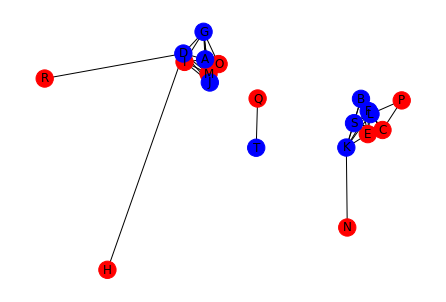

In [15]:
#Initial Base
make_graph(Country1.territory_list, Country2.territory_list, True)

## WAR FUNCTION

In [16]:
#WAR!!
def War(Country1,Country2):
    
    #Distribute Money to territories
    Country1.dist_money()
    Country2.dist_money()
    
    #Start the animation
    start = time.time()
    fig=plt.figure(figsize=(10,5))
    
    #each iteration is a year
    years = 0
    truth_value = True
    #loop until one country wins all the territories
#     while len(Country1.territory_list) != 0 and len(Country2.territory_list) != 0:
#     while Country1.money > 0 and Country2.money > 0:
    for count in range(800):
        #plot the Map
        G = make_graph(Country1.territory_list, Country2.territory_list,draw=True)
        clear_output(wait=True)
        display(fig)
        fig.clear()
        time.sleep(0.001)
        
        #randomizing the countries and territories to attack
        countries = [Country1, Country2]
        attacking_country = np.random.choice(countries)
        countries.remove(attacking_country)
        defending_country = countries[0]
        attacking_territory = np.random.choice(attacking_country.territory_list)
        possible_opponents = []
        for def_ter in defending_country.territory_list:
            if G.has_edge(attacking_territory.name, def_ter.name) == True:
                possible_opponents.append(def_ter)
        defending_territory = np.random.choice(possible_opponents)
        
        #one battle
        winning_territory = attacking_territory.attack(defending_territory)[0]
        losing_territory = attacking_territory.attack(defending_territory)[1]
        
        #adding and removing territories from the countries
        for country in [Country1,Country2]:
            if winning_territory in country.territory_list:
                winning_country = country
        if winning_country == Country1:
            Country1.add_territory(losing_territory)
            Country2.remove_territory(losing_territory)
            Country1.lose_battle_money(winning_territory)
        else:
            Country2.add_territory(losing_territory)
            Country1.remove_territory(losing_territory)
            Country2.lose_battle_money(winning_territory)
            
        #stop if one of the country wins
        if len(Country1.territory_list) == 0 or len(Country2.territory_list) == 0:
            make_graph(Country1.territory_list, Country2.territory_list,draw=True)
            clear_output(wait=True)
            display(fig)
            fig.clear()
            time.sleep(0.001)
            break
       

        #increase GDP of the country
        Country1.add_GDP()
        Country2.add_GDP()

        #Distribute Money
        Country1.dist_money()
        Country2.dist_money()

        #Increase Population and Soldiers
        Country1.increase_soldiers()
        Country2.increase_soldiers()
            
        years +=1



    end = time.time()
    print(years)  

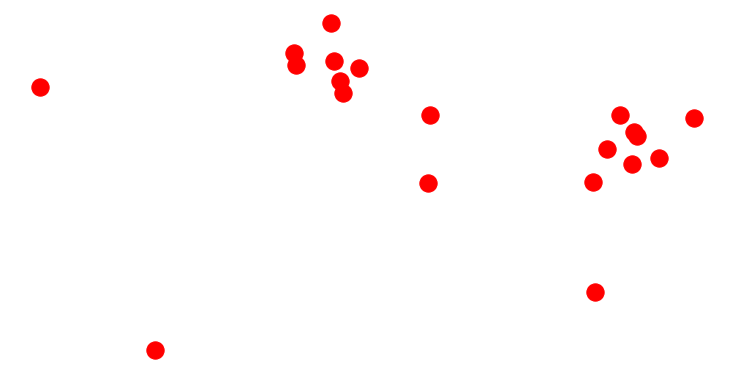

611


<Figure size 720x360 with 0 Axes>

In [17]:
"""
The visualization of war of time. This is what is happening for each time step where 2 countries are fighting over territory
"""
War(Country1,Country2)

In [18]:
def War_no_vis(Country1,Country2):
    
    #Distribute Money to territories
    Country1.dist_money()
    Country2.dist_money()
    
    #Start the animation
    
    #each iteration is a year
    years = 0
    truth_value = True
    #loop until one country wins all the territories
#     while len(Country1.territory_list) != 0 and len(Country2.territory_list) != 0:
#     while Country1.money > 0 and Country2.money > 0:
    for count in range(800):
        #plot the Map
        G = make_graph(Country1.territory_list, Country2.territory_list,draw=False)
        
        #randomizing the countries and territories to attack
        countries = [Country1, Country2]
        attacking_country = np.random.choice(countries)
        countries.remove(attacking_country)
        defending_country = countries[0]
        attacking_territory = np.random.choice(attacking_country.territory_list)
        possible_opponents = []
        for def_ter in defending_country.territory_list:
            if G.has_edge(attacking_territory.name, def_ter.name) == True:
                possible_opponents.append(def_ter)
        defending_territory = np.random.choice(possible_opponents)
        
        #one battle
        winning_territory = attacking_territory.attack(defending_territory)[0]
        losing_territory = attacking_territory.attack(defending_territory)[1]
        
        #adding and removing territories from the countries
        for country in [Country1,Country2]:
            if winning_territory in country.territory_list:
                winning_country = country
        if winning_country == Country1:
            Country1.add_territory(losing_territory)
            Country2.remove_territory(losing_territory)
            Country1.lose_battle_money(winning_territory)
        else:
            Country2.add_territory(losing_territory)
            Country1.remove_territory(losing_territory)
            Country2.lose_battle_money(winning_territory)
            
        #stop if one of the country wins
        if len(Country1.territory_list) == 0 or len(Country2.territory_list) == 0:
            break
            
        #increase GDP of the country
        Country1.add_GDP()
        Country2.add_GDP()
        
        #Distribute Money
        Country1.dist_money()
        Country2.dist_money()
        
        #Increase Population and Soldiers
        Country1.increase_soldiers()
        Country2.increase_soldiers()
        
        years +=1

    return years



In [19]:
"""
This functions will run a number of simulations on the data that we provide it so that we can get an appoximate win % 
of the factors at play. We can then use the functions later on that are built off of these to customize the territories since 
we do not have text files with specific values

"""
def run_sims(num_sims,amount1,amount2,data):

    CountryA_death_array = np.zeros(num_sims)
    CountryB_death_array = np.zeros(num_sims)
    CountryA_money_array = np.zeros(num_sims)
    CountryB_money_array = np.zeros(num_sims)
    years_of_war = np.zeros(num_sims)
    winner_of_war = []

    for i in range(num_sims):
        Country1, Country2 = take_in_data(data,amount1,amount2)
        years_of_war[i] = War_no_vis(Country1,Country2)
        CountryA_death_array[i] = (Country1.deaths)
        CountryB_death_array[i] = (Country2.deaths)
        CountryA_money_array[i] = Country1.money
        CountryB_money_array[i] = Country2.money
        
        if len(Country1.territory_list) != 0 :
            winner_of_war.append(Country1.name)   
        else:
            winner_of_war.append(Country2.name)
            
    data={"A_deaths":CountryA_death_array,
          "B_deaths": CountryB_death_array,
          "A_money": CountryA_money_array,
          "B_money" : CountryB_money_array,
          "years_of_war" :years_of_war,
          "winner": winner_of_war}
        
    df = pd.DataFrame(data)
    return df

In [29]:
#run simulations for 1000 times
df = run_sims(100,100000,100000,"Territory data.csv")
#theres a chance that nobody wins so we remove this case
no_result = sum(df["years_of_war"]== 800)
df = df[df["years_of_war"]!= 800]

In [30]:
df.describe()

,A_deaths,B_deaths,A_money,B_money,years_of_war
count,78.000000,78.000000,78.000000,78.000000,78.000000
mean,150969.358974,151523.051282,171850.013496,140228.350959,396.153846
std,71772.351358,72748.294082,162190.636611,150472.096334,191.440342
min,27770.000000,35430.000000,4435.314711,4159.363852,79.000000
25%,93228.250000,95043.000000,6561.707808,6541.642060,242.000000
50%,145418.500000,143835.500000,222795.836946,9407.497882,371.000000
75%,199153.500000,199236.750000,307058.848264,274450.410073,517.500000
max,308743.000000,307243.000000,463636.415769,454498.370488,799.000000


In [31]:
#when there is constant money:
start_data = pd.read_csv("Territory data.csv")
print("Same amount of initial money \n")
print("Simulations with No result: ",no_result,"\n")

print("Country 1")
print("started with a population of: ", sum(start_data["population"][start_data["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")
print("Mean number of casualties per war:" , np.mean(df['A_deaths']))

print("Country 2")
print("started with a population of: ", sum(start_data["population"][start_data["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")
print("Mean number of casualties per war:" , np.mean(df['B_deaths']))

print("\nResult Explanation:")
print("Country 1 has slightly more initial population, so it has more chance of winning. Also, countries are with similar strength,",no_result,"% of the wars end in no result")

Same amount of initial money 

Simulations with No result:  22 

Country 1
started with a population of:  1548436
wins : 53.85 % of the time
Mean number of casualties per war: 150969.35897435897
Country 2
started with a population of:  1533119
wins:  46.15 % of the time
Mean number of casualties per war: 151523.05128205128

Result Explanation:
Country 1 has slightly more initial population, so it has more chance of winning. Also, countries are with similar strength, 22 % of the wars end in no result


In [ ]:
# def run_sims_constant_soldiers(num_sims, amount1,amount2, data):

#     CountryA_death_array = np.zeros(num_sims)
#     CountryB_death_array = np.zeros(num_sims)
#     CountryA_money_array = np.zeros(num_sims)
#     CountryB_money_array = np.zeros(num_sims)
#     years_of_war = np.zeros(num_sims)
#     winner_of_war = []

#     for i in range(num_sims):
#         territory_data = pd.read_csv("Territory data.csv")
#         territory_data = territory_data.replace(0,"Country1")
#         territory_data = territory_data.replace(1,"Country2")

#         country_1_territory_list = []
#         country_2_territory_list = []

#         for j in range(len(territory_data)):
#             if territory_data["country"][j] == "Country1":
#                 temp_Territory = Territory(territory_data["name"][j], [territory_data["longitude"][j],territory_data["latitude"][j] ],150000)
#                 country_1_territory_list.append(temp_Territory)
#             else:
#                 temp_Territory = Territory(territory_data["name"][j], [territory_data["longitude"][j],territory_data["latitude"][j] ],150000)
#                 country_2_territory_list.append(temp_Territory)

#         Country1 = Country('Red',country_1_territory_list,amount1)
#         Country2 = Country('Blue',country_2_territory_list,amount2)
        
#         years_of_war[i] = War_no_vis(Country1,Country2)
#         CountryA_death_array[i] = (Country1.deaths)
#         CountryB_death_array[i] = (Country2.deaths)
#         CountryA_money_array[i] = Country1.money
#         CountryB_money_array[i] = Country2.money
        
#         if len(Country1.territory_list) != 0 :
#             winner_of_war.append(Country1.name)   
#         else:
#             winner_of_war.append(Country2.name)
            
#     data={"A_deaths":CountryA_death_array,
#           "B_deaths": CountryB_death_array,
#           "A_money": CountryA_money_array,
#           "B_money" : CountryB_money_array,
#           "years_of_war" :years_of_war,
#           "winner": winner_of_war}
        
#     df = pd.DataFrame(data)
#     return df

## Different Initial Money

In [32]:
df = run_sims(100,1000000,200000,"Territory data.csv")
no_result = sum(df["years_of_war"]== 800)

In [33]:
df = df[df["years_of_war"]!=800]

In [34]:
df.describe()

,A_deaths,B_deaths,A_money,B_money,years_of_war
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,4732.410000,12392.410000,1.206628e+06,15364.248953,21.460000
std,2872.784375,2872.784375,9.287038e+03,4168.046681,7.579105
min,730.000000,8390.000000,1.193541e+06,8288.726301,11.000000
25%,2516.500000,10176.500000,1.200797e+06,10806.525375,15.000000
50%,4195.500000,11855.500000,1.204345e+06,14666.653410,21.000000
75%,5840.000000,13500.000000,1.209797e+06,18318.781427,25.000000
max,14600.000000,22260.000000,1.240592e+06,23813.786195,47.000000


In [35]:
print("At the different initial money (5 times)\n")
print("Simulations with No result: ",no_result,"\n")
print("Country 1")
print("started with $", 1000000)
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 200000)
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

print("\nResult Explanation:")
print("Country 1 has 5 times the money so it can spend more on weaponary and training, and hence it will win in all the wars.")

At the different initial money (5 times)

Simulations with No result:  0 

Country 1
started with $ 1000000
wins : 100.0 % of the time
Country 2
started with $ 200000
wins:  0.0 % of the time

Result Explanation:
Country 1 has 5 times the money so it can spend more on weaponary and training, and hence it will win in all the wars.


In [38]:
#Different initial money (2 times)
df = run_sims(100,200000,400000,"Territory data.csv")
no_result = sum(df["years_of_war"]== 800)
df = df[df["years_of_war"]!=800]
df.describe()

,A_deaths,B_deaths,A_money,B_money,years_of_war
count,98.000000,98.000000,9.800000e+01,98.000000,98.00000
mean,27524.479592,20573.040816,6.352537e+04,584060.011939,63.22449
std,43008.251219,45894.498873,2.339595e+05,135768.305710,120.23581
min,7737.000000,0.000000,9.378168e+03,16632.530288,9.00000
25%,12901.000000,5164.000000,1.013855e+04,600219.835732,23.00000
50%,16027.500000,8290.500000,1.059008e+04,606560.358579,31.00000
75%,19222.750000,11485.750000,1.167866e+04,612354.189753,39.00000
max,281137.000000,288797.000000,1.363729e+06,876772.162019,775.00000


In [40]:
print("At the different initial money (2 times)\n")
print("Simulations with No result: ",no_result,"\n")
print("Country 1")
print("started with $", 200000)
print("started with a population of: ", sum(start_data["population"][start_data["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 400000)
print("started with a population of: ", sum(start_data["population"][start_data["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

print("\nResult Explanation:")
print("Country 2 has 2 times the money so it can spend more on weaponary and training, and hence it will win most of the wars.")

At the different initial money (2 times)

Simulations with No result:  2 

Country 1
started with $ 200000
started with a population of:  1548436
wins : 5.1 % of the time
Country 2
started with $ 400000
started with a population of:  1533119
wins:  94.9 % of the time

Result Explanation:
Country 2 has 2 times the money so it can spend more on weaponary and training, and hence it will win most of the wars.


## Data 2 (Country 1 has more territories than Country 2)

## Both have same initial money

In [41]:
#More territories in Country 1 but same money
df = run_sims(100,400000,400000,"Territory-data-2.csv")
no_result = sum(df["years_of_war"]== 800)
df = df[df["years_of_war"]!=800]
df.describe()
start_data_2= pd.read_csv("Territory-data-2.csv")

In [42]:
print("Different Populations and Territories but same money (Country 2 has higher money per territory) \n")
print("Simulations with No result: ",no_result,"\n")
print("Country 1")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_2["population"][start_data_2["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_2["population"][start_data_2["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

Different Populations and Territories but same money (Country 2 has higher money per territory) 

Simulations with No result:  21 

Country 1
started with $ 400000
started with a population of:  1889756
wins : 20.25 % of the time
Country 2
started with $ 400000
started with a population of:  1191799
wins:  79.75 % of the time


In [43]:
#More territories in Country 1 and also more money
df = run_sims(100,400000,300000,"Territory-data-2.csv")
no_result = sum(df["years_of_war"]== 800)
df = df[df["years_of_war"]!=800]
df.describe()
start_data_2= pd.read_csv("Territory-data-2.csv")

In [49]:
print("Different Populations and Territories and different initial money (should be close) \n")
print("Simulations with No result: ",no_result,"\n")
print("Country 1")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_2["population"][start_data_2["country"]==0]))
print("started with money per territory: ",400000/sum(start_data_2["country"]==0))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 300000)
print("started with a population of: ", sum(start_data_2["population"][start_data_2["country"]==1]))
print("started with money per territory: ",300000/sum(start_data_2["country"]==1))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

Different Populations and Territories and different initial money (should be close) 

Simulations with No result:  18 

Country 1
started with $ 400000
started with a population of:  1889756
started with money per territory:  33333.333333333336
wins : 73.17 % of the time
Country 2
started with $ 300000
started with a population of:  1191799
started with money per territory:  37500.0
wins:  26.83 % of the time


## Data 3

In [50]:
df = run_sims(100,400000,400000,"Territory-data-3.csv")
no_result = sum(df["years_of_war"]== 800)
df = df[df["years_of_war"]!=800]
df.describe()
start_data_3= pd.read_csv("Territory-data-3.csv")

In [52]:
print("Different Populations but same number of territory and money \n")
print("Simulations with No result: ",no_result,"\n")
print("Country 1")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_3["population"][start_data_3["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_3["population"][start_data_3["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

Different Populations but same number of territory and money 

Simulations with No result:  22 

Country 1
started with $ 400000
started with a population of:  2032072
wins : 73.08 % of the time
Country 2
started with $ 400000
started with a population of:  991223
wins:  26.92 % of the time


In [53]:
df = run_sims(100,400000,600000,"Territory-data-3.csv")
no_result = sum(df["years_of_war"]== 800)
df = df[df["years_of_war"]!=800]
df.describe()
start_data_3= pd.read_csv("Territory-data-3.csv")

In [54]:
print("Different Populations and money but same number of territory \n")
print("Simulations with No result: ",no_result,"\n")
print("Country 1")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_3["population"][start_data_3["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 800000)
print("started with a population of: ", sum(start_data_3["population"][start_data_3["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

Different Populations and money but same number of territory 

Simulations with No result:  9 

Country 1
started with $ 400000
started with a population of:  2032072
wins : 10.99 % of the time
Country 2
started with $ 800000
started with a population of:  991223
wins:  89.01 % of the time


In [58]:
df = run_sims(100,400000,500000,"Territory-data-3.csv")
no_result = sum(df["years_of_war"]== 800)
df = df[df["years_of_war"]!=800]
df.describe()
start_data_3= pd.read_csv("Territory-data-3.csv")

In [59]:
print("Different Populations and money but same number of territory \n")
print("Simulations with No result: ",no_result,"\n")
print("Country 1")
print("started with $", 400000)
print("started with a population of: ", sum(start_data_3["population"][start_data_3["country"]==0]))
print("wins :", round(len(df[df["winner"]=="Red"])/len(df) *100,2), "% of the time")

print("Country 2")
print("started with $", 500000)
print("started with a population of: ", sum(start_data_3["population"][start_data_3["country"]==1]))
print("wins: ", round(len(df[df["winner"]=="Blue"])/len(df) *100,2), "% of the time")

Different Populations and money but same number of territory 

Simulations with No result:  23 

Country 1
started with $ 400000
started with a population of:  2032072
wins : 46.75 % of the time
Country 2
started with $ 500000
started with a population of:  991223
wins:  53.25 % of the time
